# Notebook 4: Perceptrons and Multilayer Neural Networks

COSI/ECON-148B-1 : Introduction to Machine Learning with Economic Applications

Zizhang Chen

[zizhang2@brandeis.edu](mailto:zizhang2@brandeis.edu)

### 1, A brief example of Multilayer Neural Networks in sklearn

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random

random.seed(2023)

In [2]:
data_train = pd.read_csv("Training.csv")
data_test = pd.read_csv("Test.csv")

X_train = data_train.loc[:, data_train.columns!='Label']
Y_train = data_train.loc[:, 'Label']
X_test = data_test.loc[:, data_test.columns!='Label']
Y_test = data_test.loc[:, 'Label']

In [3]:
MLP_sklearn = MLPClassifier(hidden_layer_sizes=(50,10), max_iter=1000)

In [4]:
MLP_sklearn.fit(X_train, Y_train)
Y_pred = MLP_sklearn.predict(X_test)

In [5]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.91      0.88       200
     class 1       0.90      0.84      0.87       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.87       400
weighted avg       0.88      0.88      0.87       400



### 2, Implement a two-layer neural network from scratch with introduction

##### 2.1 Parameter initialization 

Set the initial values of the weights and biases of the neurons in the network. 

<div>
<img src="init.png" width="300"/>
</div>

Initializing the weights and biases properly is important because it can affect the **convergence speed and accuracy of the neural network during training.**

Some popular initialization: 

**Xavier initialization** (Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010))

On the $l^{th}$ layer we have:

\begin{aligned}
W^{[l]} & \sim \mathcal{N}\left(\mu=0, \sigma^2\right) \\
b^{[l]} & =0 \\
\sigma & = \sqrt{\frac{2}{n_{in} + n_{out}}}
\end{aligned}

Where $n_{in}$ and $n_{out}$ in the input and output dimension.

**He initialization** (Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015))

On the $l^{th}$ layer we have:

\begin{aligned}
W^{[l]} & \sim \mathcal{N}\left(\mu=0, \sigma^2\right) \\
b^{[l]} & =0 \\
\sigma & = \sqrt{\frac{\text{gain}}{n_{in}}}
\end{aligned}

Where $n_{in}$ in the input dimension and $\text{gain}$ is determined by the activation function we will discuss later. For Relu, $gain=2$

Implementation of the above two initilizations

In [6]:
def xavier_init(n_in, n_out):
    std_dev = np.sqrt(2.0 / (n_in + n_out))
    W = np.random.normal(0, std_dev, (n_in, n_out))
    return W

def he_init(n_in, n_out, gain=2):
    std_dev = np.sqrt(gain / n_in)
    W = np.random.normal(0, std_dev, (n_in, n_out))
    return W

#### 2.2 Activation function

In short, the activation function determines to what extent the message from the current neuron will go to the next neuron (or whether or not the present neuron will be activated). 

An activation function takes the weighted sum of inputs and produces an output. 

<div>
<img src="act.png" width="500"/>
</div>

**Softmax** usually used in output neurons (output layer) in a classification problem. It produces a probability distribution of each class that sums to 1. 


$$
    \operatorname{Softmax}\left(x_i\right)=\frac{\exp \left(x_i\right)}{\sum_j \exp \left(x_j\right)}
$$

Let's see an example

In [7]:
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

x = np.array([1, 2, 3, 4, 5])
x = x.reshape(-1, len(x)) # one row of a matrix
softmax_output = softmax(x)

print(softmax_output, 'sum to', np.sum(softmax_output))

[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]] sum to 1.0


**Relu** (Rectified Linear Unit) is usually used in input and hidden neurons (hidden layer). It outputs the input if it is positive and zero otherwise. It determines whether a neuron should be activated or not.


$$
    \operatorname{ReLU}(x)=(x)^{+}=\max (0, x)
$$

Let's see an example

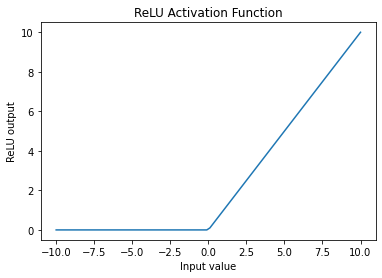

In [8]:
def relu(X):
    return np.maximum(0, X)

X = np.linspace(-10, 10, 100)
y = relu(X)

# Plot the results
plt.plot(X, y)
plt.xlabel('Input value')
plt.ylabel('ReLU output')
plt.title('ReLU Activation Function')
plt.show()

##### 2.3 Forward process

<div>
<img src="forward.png" width="500"/>
</div>

**Forward process** take the input data and pass it through each layer to produce an output or prediction.

For a 2-layer neural network use ReLU activation function in hidden layer and Softmax activation function in out out layer, we have: 

$$ Z^{[1]} = W^{[1]} X + b^{[1]} $$

$$ A^{[1]} = g^{[1]}(Z^{[1]}) = \text{ReLU}(Z^{[1]}) $$

$$ Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]} $$

$$ A^{[2]} = g^{[2]}(Z^{[2]}) = \text{softmax}(Z^{[2]}) $$

$X$: input data

$W^{[1]}$: weight parameter of hidden layer

$b^{[1]}$: bias vector of hidden layer

$Z^{[1]}$: weighted sum

$A^{[1]}$: activation of the hidden layer, it is passed to the next layer

$W^{[2]}$: weight parameter of output layer 

$b^{[2]}$: bias vector of output layer

$Z^{[2]}$: weighted sum

$A^{[2]}$: activation of the output layer

##### 2.4 Loss function

2.4.1 Loss function measures the difference between the predicted and the actual values.

Some commonly used loss functions:

**Cross entropy loss**: commonly used for classification problem

$$L=-\frac{1}{n} \sum_{i=1}^n y_i \cdot \log \left(\hat{y}_i\right)$$

where $n$ is the number of data, $y_i$ is the ground true label of data $i$(one hot encoded), $\hat{y}_i$ is the predicted probability.

Here is an example for illustration. Assume all x belongs to 'class 1', **the higher the probability, the lower the cross entropy loss**


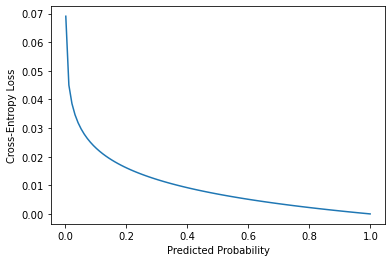

In [9]:
x = np.linspace(0.001, 0.999, 100)
y_true = np.ones(len(x))
y_loss = -y_true * np.log(x) / len(x)
plt.plot(x, y_loss)
plt.xlabel('Predicted Probability')
plt.ylabel('Cross-Entropy Loss')
plt.show()

**Mean Square Error loss**: commonly used for regression problem

$$L=\frac{1}{n} \sum_{i=1}^n\left(y_i-\tilde{y}_i\right)^2$$

2.4.2 The goal of training a neural network is to **minimize its loss function**.

**Gradient decent**: minimize the loss function during the training process.

<div>
<img src="grad.png" width="400"/>
</div>

It iteratively adjusting the weights in the direction of the steepest descent of the loss function with respect to the parameters.


In short the model parameter is updated as:

$$
W=W -\alpha \nabla L
$$

$\alpha$: learning rate, a small scaler, it controls the step size at which the optimizer updates the model parameters during training

##### 2.5 Backward process

**2.5.1 Compute the graidents**, here, for example, we use $dZ$ to denoate the gradent of loss function $L$ with respect to $Z$, 

Ie. $\frac{\partial L}{\partial Z} = dZ$

Derivative of cross entropy loss with softmax functon: $ dZ^{[2]} = A^{[2]} - Y $

$$ dW^{[2]} = \frac{1}{n} dZ^{[2]} A^{[1]T} $$

$$ db^{[2]} = \frac{1}{n} \sum_{i=1}^{n} dZ^{[2]} $$

$$ dZ^{[1]} = (W^{[2]T} dZ^{[2]}) * ReLU(Z^{[1]}) $$

$$ dW^{[1]} = \frac{1}{n} dZ^{[1]} X^T $$

$$ db^{[1]} = \frac{1}{n} \sum_{i=1}^{n} dZ^{1} $$

$Y$: the ground true label (in one-hot encoding)

$n$: number of data


**2.5.2 Update the parameters**, here, we use gradient decents to update the parameters

$$ W^{[2]} = W^{[2]} - \alpha dW^{[2]} $$

$$ b^{[2]} = b^{[2]} - \alpha db^{[2]} $$

$$ W^{[1]} = W^{[1]} - \alpha dW^{[1]} $$

$$ b^{[1]} = b^{[1]} - \alpha db^{[1]} $$

where $\alpha$ is the learning rate.

In [10]:
class NeuralNetwork_numpy:
    def __init__(self, input_size, hidden_size, output_size):
        
        # Xaview initialization
        self.W1 = xavier_init(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = xavier_init(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        
    
    def forward(self, X):
        
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)
        
        return self.a2
    
    def backward(self, X, y, learning_rate):
        # y is for vector
        dz2 = self.a2
        dz2[range(len(X)), y] -= 1
        
        dW2 = np.dot(self.a1.T, dz2) / len(X)
        db2 = np.sum(dz2, axis=0, keepdims=True) / len(X)
        
        dz1 = np.dot(dz2, self.W2.T) * (self.z1 > 0)
        dW1 = np.dot(X.T, dz1) / len(X)
        db1 = np.sum(dz1, axis=0) / len(X)
        
        # Update the weights and biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
    
    
    def train(self, X, y, num_epochs, learning_rate):
        
        # Train the network using mini-batch stochastic gradient descent
        for i in tqdm(range(num_epochs)):

            a2 = self.forward(X)
            self.backward(X, y, learning_rate)
            
    def predict(self, X):
        # Predict the class labels for the input data
        y_pred = np.argmax(self.forward(X), axis=1)
        return y_pred

In [11]:
X_train_arr = X_train.to_numpy()
Y_train_arr = Y_train.to_numpy()

X_test_arr = X_test.to_numpy()
Y_test_arr = Y_test.to_numpy()

MLP_numpy = NeuralNetwork_numpy(12, 6, 2)
MLP_numpy.train(X_train_arr, Y_train_arr, learning_rate=0.015, num_epochs=1000)
Y_pred_arr = MLP_numpy.predict(X_test_arr)

100%|██████████| 1000/1000 [00:00<00:00, 3135.39it/s]


In [12]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test_arr, Y_pred_arr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.90      0.81      0.85       200
     class 1       0.83      0.91      0.86       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



### 3, After class: implement the same neural network in Pytorch

In [ ]:
  v